<a href="https://colab.research.google.com/github/shubymao/comp551-p3/blob/shuby-dev/Project_3_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3 - Convolution Neural Network

## Team Members

Le-Li Mao (260800098)

Victor Livernoche (260926276)

Enan Ashaduzzaman (260805923)

## Initializing Dependency

In [22]:
from __future__ import print_function
import pickle as pkl
import numpy as np
import argparse
from tqdm import tqdm
from sklearn.preprocessing import normalize
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import TensorDataset, DataLoader, random_split
import torchvision.transforms.functional as TF
from torchvision.transforms import *
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import string
from google.colab import drive
drive.mount('/content/drive')
# print(torch.cuda.get_device_name(0))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cpu


## Loading Data

In [2]:
mapping = list(string.ascii_lowercase) 
training_data, training_labels, testing_data = None, None, None
with open("/content/drive/My Drive/data/images_l.pkl", 'rb') as f: 
    training_data = pkl.load(f)
    validation_size = training_data.shape[0]//10
    validation_data = training_data[0:validation_size]
    training_data = training_data[validation_size:]
with open("/content/drive/My Drive/data/labels_l.pkl", 'rb') as f: 
    training_labels = pkl.load(f)
    validation_size = training_labels.shape[0]//10
    validation_labels = training_labels[0:validation_size]
    training_labels = training_labels[validation_size:]
with open("/content/drive/My Drive/data/images_test.pkl", 'rb') as f: 
    testing_data = pkl.load(f)

## Preprocessing

### Preprocessing Helper Functions

In [3]:
def convert_labels_to_readables(labels):
  readables = []
  for label in labels:
    l1, l2 = int(label[0]), mapping[label[1].int()]
    readables.append((l1,l2,))
  return readables

In [4]:
# show images
def img_grid(row,col,imgs):
  if imgs is None: return
  for r in range(row):
    fig, axs = plt.subplots(nrows=1, ncols=col, figsize=(7.,10.))
    for i, ax in enumerate(axs.flatten()):
        if(len(imgs) <= r*col+i): 
          return
        plt.sca(ax)
        plt.imshow(imgs[r*col+i])    
    # plt.colorbar()
    plt.show()

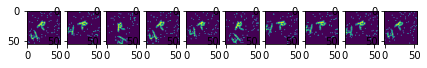

In [60]:
affine_manager = RandomAffine(45, scale = (0.9,1.1),  shear = 5)
def generate_affine(image_tensor, num):
    outputs = []
    for _ in range(num):
      outputs.append(affine_manager(image_tensor))
    return outputs

sample_tensor = torch.from_numpy(training_data[100,None]).float()
affined_tensors = map(lambda x: x[0], generate_affine(sample_tensor,9))
img_grid(1,10,[sample_tensor[0],*affined_tensors])

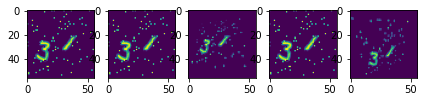

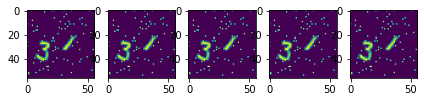

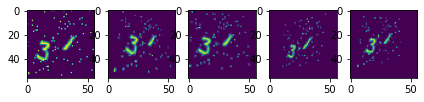

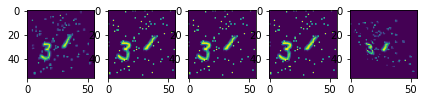

In [59]:
perspective_manager = RandomPerspective(0.5)
def generate_pespective(image_tensor, num):
    outputs = []
    for _ in range(num):
      outputs.append(perspective_manager(image_tensor))
    return outputs

sample_tensor = torch.from_numpy(training_data[2000,None]).float()
perspective_tensors = map(lambda x: x[0], generate_pespective(sample_tensor,19))
img_grid(4,5,[sample_tensor[0],*perspective_tensors])

In [64]:
# transform all data to the output format
def process_training_data(data, labels, affine_cnt = 0, perspective_cnt = 0):
  multiplier = (1+affine_cnt+perspective_cnt)
  data_tensor = torch.from_numpy(data[:,None]).float()
  new_data = torch.empty((len(data)*multiplier,1,56,56))
  num_labels = torch.empty(len(data)*multiplier)
  letter_labels = torch.empty(len(data)*multiplier)
  output_index = 0
  for i in tqdm(range(len(data_tensor))):
    # Assign the labels to the new data
    num_labels[i*multiplier:(i+1)*multiplier] = int(np.argmax(labels[i,0:10]))
    letter_labels[i*multiplier:(i+1)*multiplier] = int(np.argmax(labels[i,10:]))
    # Creating the rotation and sharpness images
    norm_img = torch.clip(data_tensor[i],0,255)
    mean, std = torch.mean(norm_img), torch.std(norm_img)
    norm_img = TF.normalize(norm_img, [mean], [std])
    new_data[output_index] = norm_img; output_index+=1
    for r_img in generate_affine(norm_img, affine_cnt):
      new_data[output_index] = r_img; output_index+=1
    for s_img in generate_pespective(norm_img, perspective_cnt):
      new_data[output_index] = s_img; output_index+=1
  
  # Creating the datasets
  multi_label_tensor = torch.stack((num_labels,letter_labels), axis=1).long()
  dataset = TensorDataset(new_data, multi_label_tensor)
  return dataset
  

In [8]:
def process_testing_data(data):
  data_tensor = torch.from_numpy(data[:,None]).float()
  dataset = torch.empty((len(data),1,56,56))
  for i in tqdm(range(len(data_tensor))):
    mean, std = torch.mean(data_tensor[i]), torch.std(data_tensor[i])
    norm_img = TF.normalize(data_tensor[i], [mean], [std])
    dataset[i] = norm_img
  return dataset
testing_dataset = process_testing_data(testing_data)

100%|██████████| 15000/15000 [00:01<00:00, 11229.05it/s]


### Processing The Data

Process the data and put the data into dataloader

In [66]:
def make_data_loader(dataset, batch_size=30, shuffle=True, num_workers=2):
  dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = shuffle, num_workers = num_workers)
  return dataloader

print("Processing Training Data")
training_dataset = process_training_data(training_data, training_labels, 6, 0)
print("Processing Validation Data")
validation_dataset = process_training_data(validation_data,validation_labels)

training_loader = make_data_loader(training_dataset)
validation_loader = make_data_loader(validation_dataset)

Processing Training Data


100%|██████████| 27000/27000 [01:08<00:00, 392.94it/s]


Processing Validation Data


100%|██████████| 3000/3000 [00:00<00:00, 8157.34it/s]


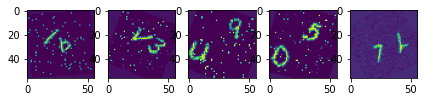

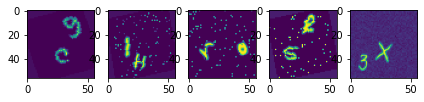

[(1, 'b'), (3, 'v'), (9, 'u'), (5, 'd'), (7, 'l'), (9, 'c'), (1, 'h'), (0, 'r'), (5, 'r'), (3, 'x')]


In [65]:
def show_sample(n):
  perm = torch.randperm(len(training_dataset))
  idx = perm[:n]
  data, labels = training_dataset[idx]
  img_grid(n//5,5 , data[:,0])
  print(convert_labels_to_readables(labels))
show_sample(10)

## Training Model

### Multi-Output Model

Initalize the Multilabel Model

In [ ]:
class MultiNet(nn.Module):
    def __init__(self):
        super(MultiNet, self).__init__()
         # 4 convolution layer
        self.conv1 = nn.Conv2d(1, 64, 3, padding='same')
        self.conv2 = nn.Conv2d(64, 64, 3, padding='same')
        self.conv3 = nn.Conv2d(64, 128, 3, padding='same')
        self.conv4 = nn.Conv2d(128, 256, 3, padding='same')
        
        self.pool2 = nn.MaxPool2d(2, 2)

        # 3 Dense Layer
        self.fc11 = nn.Linear(256*3*3, 1000)
        self.fc12 = nn.Linear(256*3*3, 1000)
        self.fc21 = nn.Linear(1000, 100)
        self.fc22 = nn.Linear(1000, 1000)
        self.fc31 = nn.Linear(100, 10)
        self.fc32 = nn.Linear(1000, 26)

    def forward(self, x):
        # Convolution Layers
        x = F.relu(self.conv1(x))
        x = self.pool2(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool2(x)
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        # print(x.size())
        # Dense Layers
        x = x.view(-1,self.num_flat_features(x)) # Flatten
        l1 = F.relu(self.fc21(F.relu(self.fc11(x))))
        l2 = F.relu(self.fc22(F.relu(self.fc12(x))))
        l1 = self.fc31(l1)
        l2 = self.fc32(l2)
        return l1,l2
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

### Custom Res Net with Multi Output




In [29]:
class Block(nn.Module):
  def __init__(self, inplane, outplane, stride = 1):
    super(Block, self).__init__()
    self.inplane = inplane
    self.outplane = outplane
    self.relu = nn.ReLU(inplace=True)
    
    self.conv1 = nn.Conv2d(inplane, outplane, 3, padding=1, bias=False, stride=stride)
    self.bn1 = nn.BatchNorm2d(outplane)
    self.conv2 = nn.Conv2d(outplane, outplane, 3, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(outplane)
    
    self.convi, self.bni = nn.Identity(), nn.Identity()
    if inplane != outplane or stride != 1: 
      self.convi = nn.Conv2d(inplane, outplane, 1, bias=False, stride=stride)
      self.bni = nn.BatchNorm2d(outplane)
  
  def forward(self, x):
        identity = self.bni(self.convi(x))

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out

class CustomResNet(nn.Module):
    def __init__(self, channel_size = 20):
        super(CustomResNet, self).__init__()
        
        self.conv1 = nn.Conv2d(1, channel_size, 3, padding=2, bias=False)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.bn1 = nn.BatchNorm2d(channel_size)
        
        # 4 Layers
        self.layer1 = nn.Sequential(
            Block(channel_size, channel_size),
            Block(channel_size, channel_size),
            Block(channel_size, channel_size)
        )
      
        self.layer2 = nn.Sequential(
            Block(channel_size, 1.5*channel_size, 2),
            Block(1.5*channel_size, 1.5*channel_size),
            Block(1.5*channel_size, 1.5*channel_size)
        )

        self.layer3 = nn.Sequential(
            Block(1.5*channel_size, 2.5*channel_size, 2),
            Block(2.5*channel_size, 2.5*channel_size),
            Block(2.5*channel_size, 2.5*channel_size)
        )
      
        self.layer4 = nn.Sequential(
            Block(2.5*channel_size, 4*channel_size, 2),
            Block(4*channel_size, 4*channel_size),
            Block(4*channel_size, 4*channel_size)
        )

        # self.layer4 = self._make_layer(models.resnet.BasicBlock, 512, 1, stride=2)
        self.avgpool = nn.AvgPool2d(3, stride=1)
        self.fc1 = nn.Linear(2*2*4*channel_size, 10)
        self.fc2 = nn.Linear(2*2*4*channel_size, 26)        

    def forward(self, x):
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        l1 = self.fc1(x)
        l2 = self.fc2(x)
        return l1,l2


### Training and Validation

#### Training Helper Function

Initialize network validation and training function

In [67]:
def validate_network(net):
  print("Starting Network Validation")
  for i, validation_data in enumerate(tqdm(validation_loader)):
    inputs, labels = validation_data
    o1, o2 = net(inputs)
    l1, l2 = labels[:,0], labels[:,1]
    digit_acc += torch.mean((torch.argmax(o1, dim=1) == l1).float()).float()
    letter_acc += torch.mean((torch.argmax(o2, dim=1) == l2).float()).float()
  digit_acc = digit_acc/len(validation_loader)
  letter_acc = letter_acc / len(validation_loader)
  print(f'Digit Accuracy: {digit_acc.item()}, Letter Accuracy: {letter_acc.item()}')

In [68]:
multi_net_criterion = nn.CrossEntropyLoss()
def criterion(output, labels):
    o1, o2 = output
    l1, l2 = labels[:,0], labels[:,1]
    loss1 = multi_net_criterion(o1,l1)
    loss2 = multi_net_criterion(o2,l2)
    return loss1 + loss2

In [69]:
def backward(net, data, optimizer, criterion = criterion):
  inputs, labels = data
  optimizer.zero_grad()
  outputs = net(inputs)
  loss = criterion(outputs, labels)
  loss.backward()
  optimizer.step()
  return loss.item()

In [70]:
def train_network(net, optimizer, scheduler, epoch_to_run = 1):
  running_loss, cnt = 0.0, 0
  last_index = len(training_loader) * (epoch_to_run - int(epoch_to_run))
  epoch_to_run = int(epoch_to_run) + 1
  for epoch in range(epoch_to_run):
    for i, data in enumerate(tqdm(training_loader)):
      if epoch == epoch_to_run - 1 and i > last_index:
        break
      running_loss += backward(net, data, optimizer)
      cnt+=1
      if i % 100 == 99:
        scheduler.step()
        print('[%d] loss: %.3f' % (i // 100, running_loss / cnt))
        running_loss, cnt = 0.0, 0
  validate_model(net)

#### Training New Network

In [33]:
lr, momentum, weight_decay, gamma = 0.01, 0.9, 1e-4, 0.95
net = CustomResNet(25)
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
scheduler = ExponentialLR(optimizer, gamma=gamma)
net = train_model(net, optimizer, scheduler, epoch)

Starting Training Iteration


  2%|▏         | 100/6300 [01:06<1:08:19,  1.51it/s]

[0] loss: 5.896


  3%|▎         | 200/6300 [02:12<1:07:07,  1.51it/s]

[1] loss: 5.391


  5%|▍         | 300/6300 [03:18<1:06:01,  1.51it/s]

[2] loss: 5.247


  6%|▋         | 400/6300 [04:24<1:04:51,  1.52it/s]

[3] loss: 5.110


  8%|▊         | 500/6300 [05:30<1:03:49,  1.51it/s]

[4] loss: 4.995


 10%|▉         | 600/6300 [06:36<1:02:43,  1.51it/s]

[5] loss: 4.793


 11%|█         | 700/6300 [07:42<1:01:30,  1.52it/s]

[6] loss: 4.521


 13%|█▎        | 800/6300 [08:48<1:00:14,  1.52it/s]

[7] loss: 4.321


 14%|█▍        | 900/6300 [09:54<59:18,  1.52it/s]

[8] loss: 4.028


 16%|█▌        | 1000/6300 [11:00<58:08,  1.52it/s]

[9] loss: 3.846


 17%|█▋        | 1100/6300 [12:06<57:19,  1.51it/s]

[10] loss: 3.499


 19%|█▉        | 1200/6300 [13:11<55:08,  1.54it/s]

[11] loss: 3.292


 21%|██        | 1300/6300 [14:17<55:04,  1.51it/s]

[12] loss: 2.924


 22%|██▏       | 1400/6300 [15:22<52:52,  1.54it/s]

[13] loss: 2.716


 24%|██▍       | 1500/6300 [16:27<51:58,  1.54it/s]

[14] loss: 2.465


 25%|██▌       | 1600/6300 [17:32<50:54,  1.54it/s]

[15] loss: 2.338


 27%|██▋       | 1700/6300 [18:37<49:54,  1.54it/s]

[16] loss: 2.186


 29%|██▊       | 1800/6300 [19:43<48:55,  1.53it/s]

[17] loss: 2.014


 30%|███       | 1900/6300 [20:48<47:46,  1.53it/s]

[18] loss: 1.814


 32%|███▏      | 2000/6300 [21:53<46:56,  1.53it/s]

[19] loss: 1.686


 33%|███▎      | 2100/6300 [22:58<45:24,  1.54it/s]

[20] loss: 1.651


 35%|███▍      | 2200/6300 [24:03<44:14,  1.54it/s]

[21] loss: 1.580


 37%|███▋      | 2300/6300 [25:08<43:13,  1.54it/s]

[22] loss: 1.457


 38%|███▊      | 2400/6300 [26:13<42:12,  1.54it/s]

[23] loss: 1.414


 40%|███▉      | 2500/6300 [27:18<41:26,  1.53it/s]

[24] loss: 1.329


 41%|████▏     | 2600/6300 [28:23<40:10,  1.53it/s]

[25] loss: 1.287


 43%|████▎     | 2700/6300 [29:28<38:57,  1.54it/s]

[26] loss: 1.216


 44%|████▍     | 2800/6300 [30:33<38:09,  1.53it/s]

[27] loss: 1.184


 46%|████▌     | 2900/6300 [31:38<36:57,  1.53it/s]

[28] loss: 1.142


 48%|████▊     | 3000/6300 [32:43<35:41,  1.54it/s]

[29] loss: 1.063


 49%|████▉     | 3100/6300 [33:47<34:33,  1.54it/s]

[30] loss: 1.053


 51%|█████     | 3200/6300 [34:52<33:22,  1.55it/s]

[31] loss: 1.015


 52%|█████▏    | 3300/6300 [35:57<32:33,  1.54it/s]

[32] loss: 0.963


 54%|█████▍    | 3400/6300 [37:02<31:17,  1.54it/s]

[33] loss: 0.946


 56%|█████▌    | 3500/6300 [38:08<30:28,  1.53it/s]

[34] loss: 0.840


 57%|█████▋    | 3600/6300 [39:13<29:16,  1.54it/s]

[35] loss: 0.892


 59%|█████▊    | 3700/6300 [40:18<28:06,  1.54it/s]

[36] loss: 0.870


 60%|██████    | 3800/6300 [41:23<26:59,  1.54it/s]

[37] loss: 0.806


 62%|██████▏   | 3900/6300 [42:27<25:57,  1.54it/s]

[38] loss: 0.843


 63%|██████▎   | 4000/6300 [43:32<24:58,  1.54it/s]

[39] loss: 0.778


 65%|██████▌   | 4100/6300 [44:37<23:54,  1.53it/s]

[40] loss: 0.752


 67%|██████▋   | 4200/6300 [45:42<22:48,  1.53it/s]

[41] loss: 0.795


 68%|██████▊   | 4300/6300 [46:47<21:37,  1.54it/s]

[42] loss: 0.718


 70%|██████▉   | 4400/6300 [47:52<20:31,  1.54it/s]

[43] loss: 0.762


 71%|███████▏  | 4500/6300 [48:57<19:29,  1.54it/s]

[44] loss: 0.681


 73%|███████▎  | 4600/6300 [50:03<18:27,  1.54it/s]

[45] loss: 0.722


 75%|███████▍  | 4700/6300 [51:08<17:16,  1.54it/s]

[46] loss: 0.645


 76%|███████▌  | 4800/6300 [52:13<16:16,  1.54it/s]

[47] loss: 0.657


 78%|███████▊  | 4900/6300 [53:18<15:08,  1.54it/s]

[48] loss: 0.739


 79%|███████▉  | 5000/6300 [54:23<14:03,  1.54it/s]

[49] loss: 0.658


 81%|████████  | 5100/6300 [55:28<12:57,  1.54it/s]

[50] loss: 0.650


 83%|████████▎ | 5200/6300 [56:33<11:51,  1.55it/s]

[51] loss: 0.609


 84%|████████▍ | 5300/6300 [57:38<10:49,  1.54it/s]

[52] loss: 0.585


 86%|████████▌ | 5400/6300 [58:43<09:48,  1.53it/s]

[53] loss: 0.631


 87%|████████▋ | 5500/6300 [59:48<08:41,  1.53it/s]

[54] loss: 0.594


 89%|████████▉ | 5600/6300 [1:00:53<07:35,  1.54it/s]

[55] loss: 0.630


 90%|█████████ | 5700/6300 [1:01:58<06:27,  1.55it/s]

[56] loss: 0.601


 92%|█████████▏| 5800/6300 [1:03:03<05:19,  1.56it/s]

[57] loss: 0.630


 94%|█████████▎| 5900/6300 [1:04:08<04:21,  1.53it/s]

[58] loss: 0.612


 95%|█████████▌| 6000/6300 [1:05:13<03:15,  1.53it/s]

[59] loss: 0.603


 97%|█████████▋| 6100/6300 [1:06:18<02:09,  1.54it/s]

[60] loss: 0.548


 98%|█████████▊| 6200/6300 [1:07:24<01:05,  1.54it/s]

[61] loss: 0.510


100%|██████████| 6300/6300 [1:08:29<00:00,  1.53it/s]


[62] loss: 0.536
Starting Validation Iteration


100%|██████████| 100/100 [00:23<00:00,  4.22it/s]


 Digit Accuracy: 0.943000316619873, Letter Accuracy: 0.9036670923233032


#### Continue Training

In [ ]:
lr, momentum, weight_decay = 0.001, 0.9, 1e-4
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
scheduler = ExponentialLR(optimizer, gamma=0.9)
train_network(net, optimizer, scheduler, epoch_to_run = 0.2)

  2%|▏         | 100/6300 [01:05<1:07:33,  1.53it/s]

[0] loss: 0.686


  3%|▎         | 200/6300 [02:10<1:05:53,  1.54it/s]

[1] loss: 0.729


  5%|▍         | 300/6300 [03:15<1:05:24,  1.53it/s]

[2] loss: 0.743


  6%|▋         | 400/6300 [04:20<1:03:18,  1.55it/s]

[3] loss: 0.720


  8%|▊         | 500/6300 [05:24<1:02:01,  1.56it/s]

[4] loss: 0.681


 10%|▉         | 600/6300 [06:28<1:01:15,  1.55it/s]

[5] loss: 0.689


 11%|█         | 700/6300 [07:33<59:59,  1.56it/s]  

[6] loss: 0.673


 13%|█▎        | 800/6300 [08:37<59:04,  1.55it/s]

[7] loss: 0.594


 14%|█▍        | 900/6300 [09:41<57:46,  1.56it/s]

[8] loss: 0.633


 15%|█▍        | 927/6300 [09:58<57:26,  1.56it/s]

## Results

Quick Sanity check

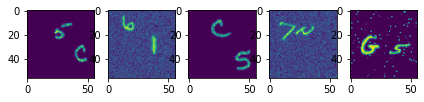

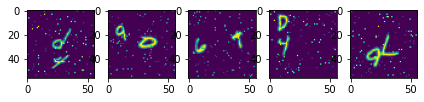

[(5, 'c'), (6, 'i'), (5, 'c'), (7, 'n'), (5, 'g'), (4, 'd'), (9, 'o'), (7, 't'), (0, 'y'), (9, 'l')]


In [ ]:
img_grid(2, 5, testing_dataset[10000:10010,0])
l1, l2 = net(testing_dataset[10000:10010])
l1 = np.argmax(l1.detach().numpy(), axis=1)
l2 = np.argmax(l2.detach().numpy(), axis=1)
print(list(zip(l1,map(lambda x: mapping[x], l2))))

In [ ]:
def LabelToString(label, isDigit):
  s = ""
  r = 0
  if (isDigit):
    r = 10
  else:
    r = 26
  for i in range(0, r):
    if (i == label):
      s += '1'
    else:
      s += '0'
  return s

category = []
k = 0
while(k<15000):
  l1,l2 = net(testing_dataset[k:k+100])
  l1 = np.argmax(l1.detach().numpy(), axis=1)
  l2 = np.argmax(l2.detach().numpy(), axis=1)
  for i in range(0, len(l1)):
    a = LabelToString(l1[i], True)
    b = LabelToString(l2[i], False)
    category.append(a+b)
    k += 1

In [ ]:
id = []
for i in range(0, 15000):
  id.append(i)
# need to create data dict
data = {
    '# Id' : id,
    'Category' : category
}

df = pd.DataFrame(data=data, columns= ['# Id', 'Category'])
print(df)
df.to_csv('/content/drive/My Drive/data/results.csv', index = False, header=True)

        # Id                              Category
0          0  100000000000000000000000000001000000
1          1  000010000000000000000100000000000000
2          2  000000000100000000010000000000000000
3          3  100000000000000000000100000000000000
4          4  000000100000000000010000000000000000
...      ...                                   ...
14995  14995  000100000000001000000000000000000000
14996  14996  000100000010000000000000000000000000
14997  14997  000000100000000000000000001000000000
14998  14998  010000000000000000100000000000000000
14999  14999  001000000000000000001000000000000000

[15000 rows x 2 columns]


In [ ]:
torch.save(res_net.state_dict(), 'res_net_v2_checkpoint.pth')